In [1]:
from final_model import CNN, predict_class
import torch
import torchtext
from my_funcs import tokenize_es_c as tokenizer
from torchtext import data
from torchtext.legacy import data
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Archivos necesarios

In [2]:
# https://drive.google.com/drive/u/0/folders/11f56BYIK7oIQD_ytIlo0m2KNzrLdIfW4

test_file = 'CNN_test.csv'
TEXT = torch.load( 'TEXT.pt')
CATEGORY = torch.load( 'CATEGORY.pt')
name = 'CNN_ep8_2021-12-14_23:09:41.769029.pt'

In [3]:
BATCH_SIZE = 64
DROPOUT = 0.6
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
MAX_VOCAB_SIZE = 50000
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = 10
EMBEDDING_DIM = 300
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [4]:
cats =  {0: '1-Mundo',
         1: '10-Salud',
         2: '2-Economía',
         3: '3-Política_y_Conflictos',
         4: '4-Ciencias_y_Tecnología',
         5: '5-Catástrofes_y_Accidentes',
         6: '6-Cultura_y_Artes',
         7: '7-Deporte',
         8: '8-Ecología_y_Planeta',
         9: '9-Crimen_delitos_y_Justicia'}

lbs = list(cats.values())

In [5]:
best_model = CNN(INPUT_DIM,
                 EMBEDDING_DIM,
                 N_FILTERS,
                 FILTER_SIZES,
                 OUTPUT_DIM,
                 DROPOUT,
                 PAD_IDX)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_NAME = str(device)
print(DEVICE_NAME)

cuda


In [8]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


best_model.load_state_dict(torch.load(name,
                                      map_location=device)['model_state_dict'])

<All keys matched successfully>

In [9]:
best_model.eval()

CNN(
  (embedding): Embedding(50002, 300)
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(3, 300), stride=(1,))
    (1): Conv1d(1, 100, kernel_size=(4, 300), stride=(1,))
    (2): Conv1d(1, 100, kernel_size=(5, 300), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=10, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [10]:
# https://www.latercera.com/pulso/noticia/banco-central-sube-proyeccion-de-crecimiento-para-este-ano-hasta-12-pero-espera-una-fuerte-desaceleracion-para-2022-y-2023/NL4LNATNH5E35LPZL56LH7G47Y/
noticia_1 = """Informe de Política Monetaria: Banco Central prevé crecimiento de 12% este año y estima que inflación se mantendrá en 7% «por algunos meses» """

In [11]:
cats[predict_class(best_model, noticia_1, TEXT, min_len=5)]

tensor([[ 0.0674, -0.5068,  6.4921,  0.3068, -1.2057, -2.8247, -4.6095, -2.7547,
         -0.4765, -1.4720]], grad_fn=<AddmmBackward0>)


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


'2-Economía'

In [12]:
# https://www.24horas.cl/nacional/minsal-estudia-iniciar-vacunacion-con-cuarta-dosis-contra-el-covid-19-en-febrero-del-2022-5103808
noticia_2 = "Minsal estudia iniciar vacunación con cuarta dosis contra el COVID-19 en febrero del 2022"

In [13]:
cats[predict_class(best_model, noticia_2, TEXT, min_len=5)]

tensor([[ 0.5732,  4.7610, -0.8346, -0.9463,  0.8126, -2.6500, -1.7945, -2.0587,
         -1.8034, -2.0930]], grad_fn=<AddmmBackward0>)


'10-Salud'

## Probando con un dataset

In [14]:
df = pd.read_csv(test_file)
# content tiene el titulo mas el texto de la noticia
# df['content'] = df[['title', 'text']].agg('. '.join, axis=1)
df.to_csv("pruebas.csv", encoding="UTF-8",index=False)

In [15]:
df.columns

Index(['id', 'title', 'content', 'category'], dtype='object')

In [16]:
# columnas del dataset de entrada
# ejemplo     id          title            content            category
# fields = [(None, None),(None, None),('content', TEXT),('category', CATEGORY)]
fields = [(None, None),(None, None),('content', TEXT),('category', CATEGORY)]

In [17]:
test_data = data.TabularDataset(
                                path = 'pruebas.csv',
                                format = 'csv',
                                fields = fields,
                                skip_header = True
)

In [18]:
test_iterator = data.BucketIterator(test_data, 
                                    batch_size = BATCH_SIZE, 
                                    device = device,
                                    sort_key=lambda x:len(x.category),
                                    sort_within_batch=False)

In [19]:
best_model = best_model.cpu()
prediction_test = []
labels_test=[]
for batch in tqdm(test_iterator, desc='predictions'):
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.content.cpu()).squeeze(1)
    prediction_test.append(predictions.argmax(dim=1).detach().numpy())
    
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

predictions: 100%|██████████████████████████████| 36/36 [00:11<00:00,  3.24it/s]


In [20]:
%matplotlib notebook
print('Resultados clasificación')
print('CNN')
print(classification_report(y_true,
                            y_pred,
                            target_names=lbs,))

Resultados clasificación
CNN
                             precision    recall  f1-score   support

                    1-Mundo       0.79      0.83      0.81       225
                   10-Salud       0.86      0.84      0.85       225
                 2-Economía       0.84      0.84      0.84       225
    3-Política_y_Conflictos       0.79      0.82      0.80       225
    4-Ciencias_y_Tecnología       0.87      0.70      0.78       225
 5-Catástrofes_y_Accidentes       0.93      0.94      0.94       225
          6-Cultura_y_Artes       0.91      0.94      0.93       225
                  7-Deporte       0.96      0.99      0.97       225
       8-Ecología_y_Planeta       0.88      0.95      0.91       225
9-Crimen_delitos_y_Justicia       0.84      0.82      0.83       225

                   accuracy                           0.87      2250
                  macro avg       0.87      0.87      0.87      2250
               weighted avg       0.87      0.87      0.87      2250



<IPython.core.display.Javascript object>


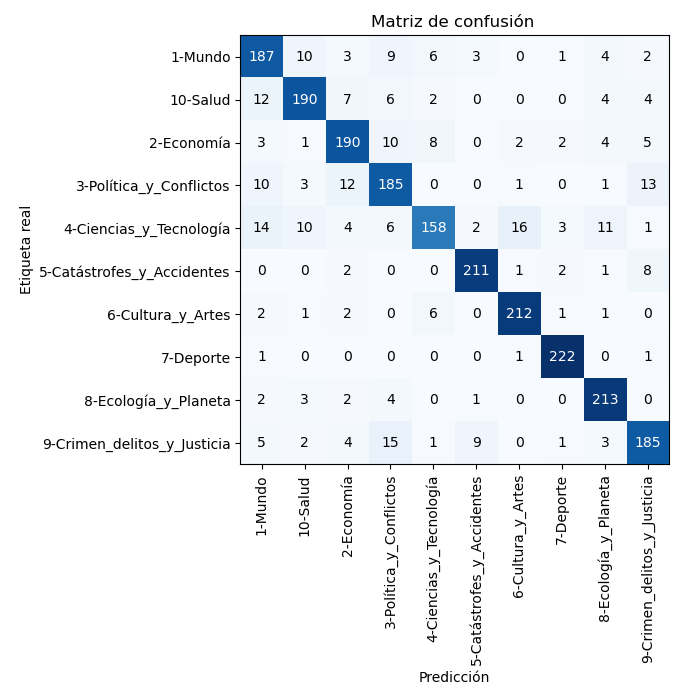

In [21]:
from my_funcs import plot_confusion_matrix
%matplotlib notebook
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm, labels=lbs)